# Taller Extra - VAR 2021-01

In [1]:
# Librerías necesarias

import cv2
import matplotlib.pyplot as plt
import numpy as np
import math
import skimage
import skimage.io
import skimage.morphology as morph

### UTILIDADES PARA LA LECTURA DE IMÁGENES
#Función de lectura rápida de imágenes a color y en escala de grises
def img_read(filename, mode = 'color'):
    if(mode == 'color'):   
        return cv2.cvtColor(cv2.imread(filename),cv2.COLOR_BGR2RGB)
    elif(mode=='grayscale' or mode=='greyscale' or mode == 'gray' or mode == 'grey'):
        return cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    else:
        return None

    #Función para interpolar los puntos entre 0 y 255
def img_scale(img, value_range = [0,255]):
    return (value_range[1] - value_range[0])*(img - np.min(img))/(np.max(img)-np.min(img)) + value_range[0]
    
    #Función para enviar los extremos superior e inferior a 0 y 255 respectivamente en la matriz
def img_trim(img, value_range = [0, 255]):
    res = img.copy()
    res[res > 255] = 255
    res[res < 0] = 0
    return res


## Actividad 1 - Umbralización 


Observe a continuación la siguiente imagen y su respectivo canal de color en diferentes espacios de colores.

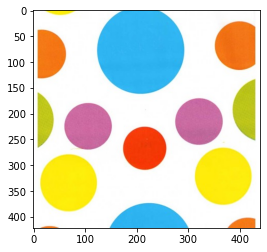

In [2]:
#Leer y plotear la imagen de trabajo
img = cv2.imread("res/colores.jpg", cv2.IMREAD_COLOR)
img_rgb  = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)

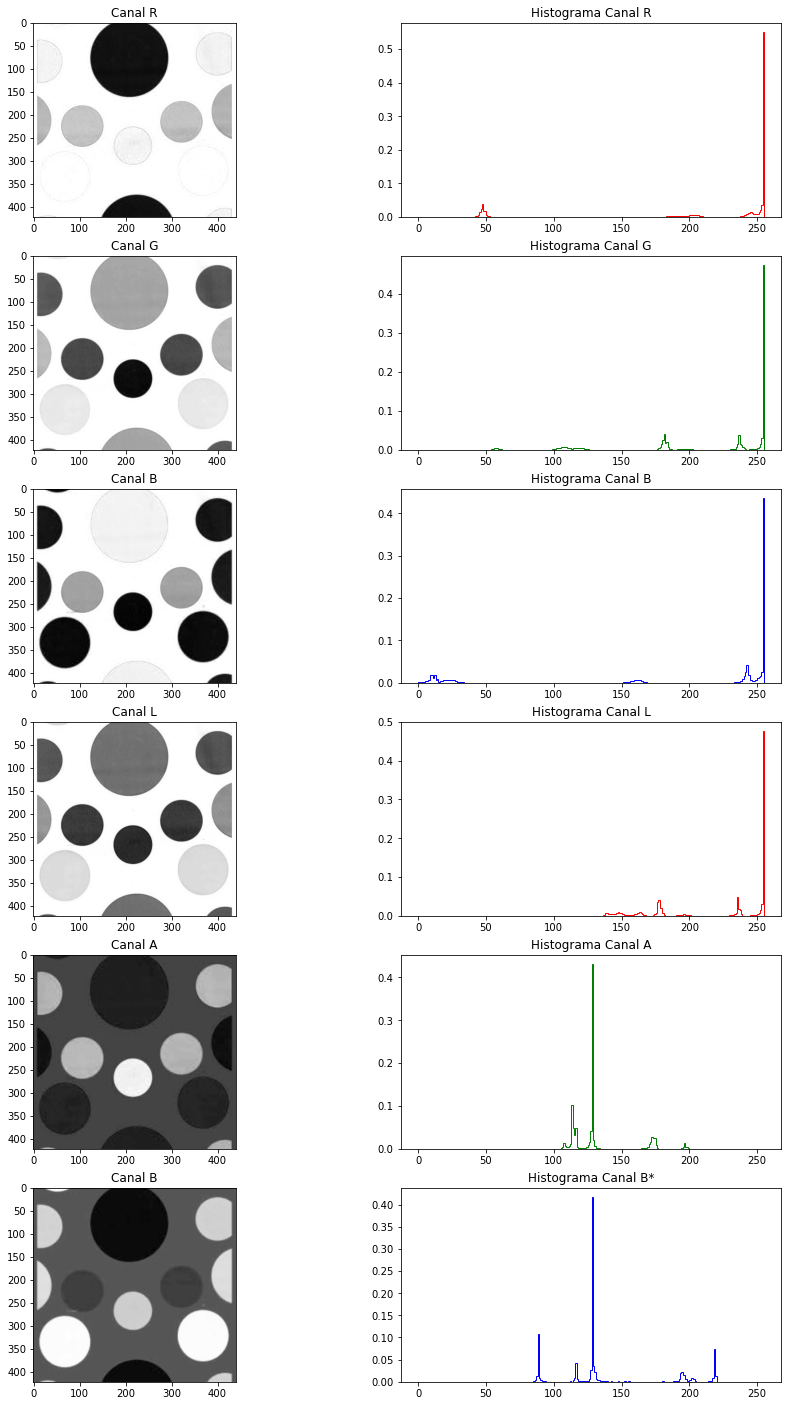

In [3]:
#Separación de canales de color
img_R = img_rgb[:,:,0] #Canal R
img_G = img_rgb[:,:,1] #Canal G
img_B = img_rgb[:,:,2] #Canal B

img_lab  = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
img_L = img_lab[:,:,0] #Canal L
img_A =  img_lab[:,:,1] #Canal A
img_BB = img_lab[:,:,2] #Canal B
fig, arreglo_plots = plt.subplots(6,2, figsize=(15, 25))
colors = ('r','g','b')

#Canal RGB
arreglo_plots[0,0].set_title('Canal R')
arreglo_plots[0,0].imshow(img_R, cmap="gray")
arreglo_plots[0,1].set_title('Histograma Canal R')
img_array_i = img_rgb[:,:,0].ravel()
arreglo_plots[0,1].hist(img_array_i,histtype='step', bins=255, 
                            range=(0.0, 255.0),density=True, color=colors[0])

arreglo_plots[1,0].set_title('Canal G')
arreglo_plots[1,0].imshow(img_G, cmap="gray")
arreglo_plots[1,1].set_title('Histograma Canal G')
img_array_i = img_rgb[:,:,1].ravel()
arreglo_plots[1,1].hist(img_array_i,histtype='step', bins=255, 
                            range=(0.0, 255.0),density=True, color=colors[1])
    
arreglo_plots[2,0].set_title('Canal B')
arreglo_plots[2,0].imshow(img_B, cmap="gray")
arreglo_plots[2,1].set_title('Histograma Canal B')
img_array_i = img_rgb[:,:,2].ravel()
arreglo_plots[2,1].hist(img_array_i,histtype='step', bins=255, 
                            range=(0.0, 255.0),density=True, color=colors[2])

#Canal LAB
arreglo_plots[3,0].set_title('Canal L')
arreglo_plots[3,0].imshow(img_L, cmap="gray")
arreglo_plots[3,1].set_title('Histograma Canal L')
img_array_i = img_lab[:,:,0].ravel()
arreglo_plots[3,1].hist(img_array_i,histtype='step', bins=255, 
                            range=(0.0, 255.0),density=True, color=colors[0])

arreglo_plots[4,0].set_title('Canal A')
arreglo_plots[4,0].imshow(img_A, cmap="gray")
arreglo_plots[4,1].set_title('Histograma Canal A')
img_array_i = img_lab[:,:,1].ravel()
arreglo_plots[4,1].hist(img_array_i,histtype='step', bins=255, 
                            range=(0.0, 255.0),density=True, color=colors[1])
    
arreglo_plots[5,0].set_title('Canal B')
arreglo_plots[5,0].imshow(img_BB, cmap="gray")
arreglo_plots[5,1].set_title('Histograma Canal B*')
img_array_i = img_lab[:,:,2].ravel()
arreglo_plots[5,1].hist(img_array_i,histtype='step', bins=255, 
                            range=(0.0, 255.0),density=True, color=colors[2]);

Siempre antes de ir a la segmentación, se debe saber que canal de color es el adecuado para poder separar lo que buscamos. <b>En este caso buscaremos separar los circulos amarillos de los demás (aproximación)</b>.

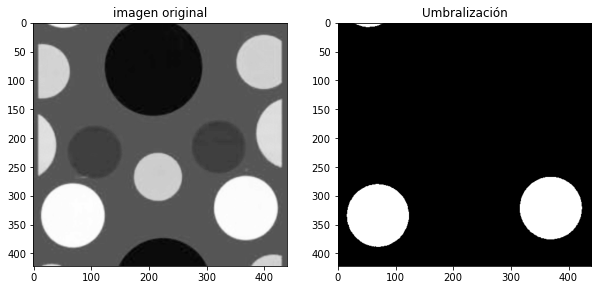

In [32]:
#Asignar el canal que se va a utilizar ≈ 1 linea
canal = img_BB
#Asignar los valores aproximados del umbral

####SU CODIGO AQUÍ##### #Solo asignar valores
val_min = 210 #    150 <= val_min >= 220
val_max = 255 #    220 <= val_max >= 255
#####TERMINA SU CODIGO#####

#Thresh_Binary
ret, thresh1 = cv2.threshold(canal,val_min,val_max,cv2.THRESH_BINARY)

#Mostrar imagen
fig2, ax = plt.subplots(1,2, figsize=(10, 7))
ax[0].set_title('imagen original')
ax[0].imshow(canal, cmap='gray')
ax[1].set_title('Umbralización')
ax[1].imshow(thresh1, cmap='gray')

## Salida esperada:

<img src = "res/answer_2.png">

# Actividad 2 - Filtros

Ahora que sabemos cómo implementar operadores basados en la primera derivada, veamos cómo funcionan los operadores de Segunda Derivada.

Dada la ausencia de dos gradientes, estos operadores se implementan mediante una única convolución.

## El filtro de la Laplaciana

<h2>$\nabla^2f(x,y)=\frac{\partial^2f}{\partial_x^2}+\frac{\partial^2f}{\partial_y^2}$</h2>

Utilizando las siguientes máscaras de convolución, implementemos el Filtro de la Laplaciana. Las llamaremos máscara 1 y máscara 2 respectivamente.

<h2>$\nabla^2f=f*\begin{bmatrix}
 1 & -2 & 1\\ 
 -2 & 4 & -2\\ 
 1 & -2 & 1
\end{bmatrix}$</h2>

<h2>$\nabla^2f=f*\begin{bmatrix}
 -1 & -1 & -1\\ 
 -1 & 8 & -1\\ 
 -1 & -1 & -1
\end{bmatrix}$</h2>

Lea la imagen "res/botones.jpg" en escala de grises.

In [ ]:
#Leer imagen de entrada en escala de grises  ≈ 1 linea

####SU CODIGO AQUÍ#####
img = img_read('res/botones.jpg', "gray")
#####TERMINA SU CODIGO#####

#Crear las máscaras de convolución  ≈ 2 lineas

####SU CODIGO AQUÍ#####
mask1 = None #máscara 1
mask2 = None #máscara 2
#####TERMINA SU CODIGO#####

print("La máscara de convolución 1 en X es: \n", mask1)
print("La máscara de convolucion 2 es: \n", mask2)

## Salida esperada:

<img src = "res/mascaralaplaciana.png">

Ahora, realizaremos las dos convoluciones respectivas y observaremos los resultados.

In [ ]:
#Realizar la convolución ≈ 2 lineas


####SU CODIGO AQUÍ#####
laplace_filtered1 = None #Convolución máscara 1
laplace_filtered2 = None #Convolución máscara 2
#####TERMINA SU CODIGO#####

#Generar subplot 1x3 para mostrar imagen original y convolución Laplaciana
fig, ax = plt.subplots(1,3, figsize=(15, 8))
ax[0].set_title('Imagen Original')
ax[0].imshow(img, cmap='gray')
ax[1].set_title('Convolucion Laplaciana 1')
ax[1].imshow(laplace_filtered1, cmap='gray')
ax[2].set_title('Convolucion Laplaciana 2')
ax[2].imshow(laplace_filtered2, cmap='gray')

## Salida esperada:

<img src = "res/convolucionlaplaciana.png">

# Actividad 3 - Intentemos

Seguir los mismos pasos de la solución de la actividad 1, puede utilizar otras técnicas de umbralización. El problema en esta actividad sera segmentar una banana, la imagen se encuentra en la siguiente dirección: "res/banana.jpg"

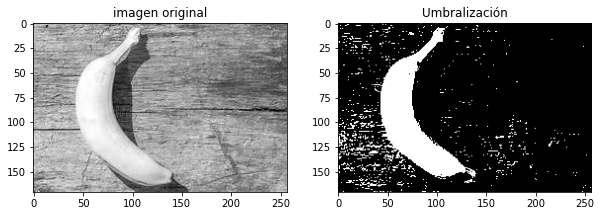

In [59]:
####SU CODIGO AQUÍ#####
img = img_read("res/banana.jpg")

img_R = img[:,:,0] #Canal G
#img_G = img[:,:,1] #Canal G

ret, thresh1 = cv2.threshold(img_R,200, 1,cv2.THRESH_BINARY)

#Mostrar imagen
fig2, ax = plt.subplots(1,2, figsize=(10, 7))
ax[0].set_title('imagen original')
ax[0].imshow(img_R, cmap='gray')
ax[1].set_title('Umbralización')
ax[1].imshow(thresh1, cmap='gray')

(array([[ 0.,  0.,  1., ..., 49., 30.,  2.],
        [ 0.,  0.,  1., ..., 58., 21.,  1.],
        [ 0.,  0.,  1., ..., 64., 10.,  0.],
        ...,
        [ 0.,  3., 12., ...,  6.,  0.,  0.],
        [ 0.,  1., 15., ...,  7.,  0.,  0.],
        [ 0.,  0., 15., ...,  5.,  0.,  0.]]),
 array([  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,
        229.5, 255. ]),
 <a list of 257 BarContainer objects>)

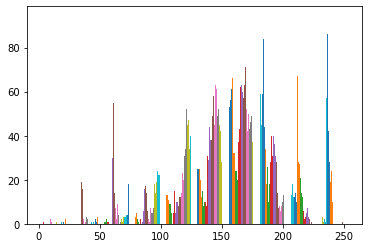

In [56]:
plt.hist(img_R)